# Problema de Negócio

Uma empresa de seguro, onde seus clientes utilizam seguro de saúde gostaria de saber se esses clientes comprariam um novo produto, um seguro de automóvel. Isso é importante para terem uma noção se esse novo produto seria viável ou não. Para sanar essa dúvida foi desenvolvida uma pesquisa que trouxe as informações sobre o cliente e quais consumidores comprariam e quais não comprariam o produto.

Existem novos clientes que não participaram da pesquisa e a empresa precisa saber se comprariam o seguro de alto-móvel ou não.

Para a venda do novo seguro foi criada uma campanha por telefone, e o limite de ligações será de 2000. O produto desenvolvido será um classificadorque crie um rank identificando os clientes mais propensos a adquirir o novo produto



# 0.0 Import Libraries, Load Data and auxiliar functions

In [105]:
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import inflection
import sklearn
import scipy.stats as stats


from sklearn.metrics import roc_curve, auc, make_scorer, precision_score
from sklearn.model_selection import cross_val_score

from IPython.display       import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection as ms

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics as mt


In [2]:
# Paleta de cores utilizada
custom_palette = ['#003366', '#006400', '#800020', '#3E2723']
sns.set_palette(custom_palette)
sns.color_palette(custom_palette)

[(0.0, 0.2, 0.4),
 (0.0, 0.39215686274509803, 0.0),
 (0.5019607843137255, 0.0, 0.12549019607843137),
 (0.24313725490196078, 0.15294117647058825, 0.13725490196078433)]

In [3]:
df_raw = pd.read_csv('data/train.csv')
# df_test = pd.read_csv('data/test.csv')

## 0.1 Separação de dados em Treino, Teste e Validação

In [4]:
df1 = df_raw.copy()

dfx = df1.drop(columns=['Response'])
dfy = df1['Response']

# Utilizei Estratificação para manter a mesma proporção entre as categorias durante o split
dfx_train, dfx_test, dfy_train, dfy_test =  ms.train_test_split(dfx, dfy, test_size = 0.2, stratify=dfy, random_state = 12)

df1 = pd.concat([dfx_train, dfy_train], axis=1)
print(dfy_train.value_counts())
print(dfy_test.value_counts())


Response
0    267519
1     37368
Name: count, dtype: int64
Response
0    66880
1     9342
Name: count, dtype: int64


## 0.2 Funções auxiliares 

In [119]:
# Função para calcular o coeficiente de Cramér's V
def cramers_v(x, y):
    # Calcula a tabela de contingência
    contingency_table = pd.crosstab(x, y)
    # Calcula o valor de chi2, p-value, graus de liberdade
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    # Calcula o coeficiente de Cramér's V
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * min(contingency_table.shape) - 1))

# 1.0 Data Description

## 1.1 Significado das colunas 

| Variable              | Definition                                                                                 |
|-----------------------|---------------------------------------------------------------------------------------------|
| `id`                 | Unique ID for the customer                                                                 |
| `Gender`             | Gender of the customer                                                                     |
| `Age`                | Age of the customer                                                                        |
| `Driving_License`    | 0: Customer does not have DL, 1: Customer already has DL                                    |
| `Region_Code`        | Unique code for the region of the customer                                                 |
| `Previously_Insured` | 1: Customer already has Vehicle Insurance, 0: Customer doesn't have Vehicle Insurance       |
| `Vehicle_Age`        | Age of the Vehicle                                                                         |
| `Vehicle_Damage`     | 1: Customer got his/her vehicle damaged in the past. 0: Customer didn't get his/her vehicle damaged in the past |
| `Annual_Premium`     | The amount customer needs to pay as premium in the year                                    |
| `Policy_Sales_Channel` | Anonymized Code for the channel of outreaching to the customer, e.g., Different Agents, Over Mail, Over Phone, In Person, etc. |
| `Vintage`            | Number of days the customer has been associated with the company                           |
| `Response`           | 1: Customer is interested, 0: Customer is not interested                                   |

## 1.2 Tipos de dados, tamanho do dataset e verificação de nulos 

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304887 entries, 336707 to 83271
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    304887 non-null  int64  
 1   Gender                304887 non-null  object 
 2   Age                   304887 non-null  int64  
 3   Driving_License       304887 non-null  int64  
 4   Region_Code           304887 non-null  float64
 5   Previously_Insured    304887 non-null  int64  
 6   Vehicle_Age           304887 non-null  object 
 7   Vehicle_Damage        304887 non-null  object 
 8   Annual_Premium        304887 non-null  float64
 9   Policy_Sales_Channel  304887 non-null  float64
 10  Vintage               304887 non-null  int64  
 11  Response              304887 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 30.2+ MB


Dataset não possui valores nulos, reduzindo trabalho de limpeza
  

In [6]:
print(f'Colunas: {df1.shape[1]}')
print(f'Linhas: {df1.shape[0]}')

Colunas: 12
Linhas: 304887


## 1.3 Renomeando colunas

In [7]:
cols = list(df1.columns)
lista = [inflection.underscore(coluna) for coluna in cols ]
df1.columns = lista
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 1.4 Estatística descritiva

In [8]:
df1.head(3)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
336707,336708,Female,23,1,30.0,1,< 1 Year,No,21620.0,152.0,138,0
193582,193583,Male,58,1,3.0,0,1-2 Year,Yes,2630.0,26.0,197,0
170385,170386,Female,24,1,28.0,0,< 1 Year,Yes,47596.0,152.0,53,0


In [9]:
# df_number = df1.select_dtypes(include = ['int64', 'float64'])
df_number = df1[['age', 'region_code','annual_premium',
                 'policy_sales_channel', 'vintage']].copy()

# df_object = df1.select_dtypes(include = ['object'])
df_object = df1[['gender', 'vehicle_age', 'vehicle_damage', 'driving_license',
                 'previously_insured', 'response']].copy()

### 1.4.1 Atributos numéricos

In [10]:
df_number.describe().T

,count,mean,std,min,25%,50%,75%,max
age,304887.0,38.812176,15.514660,20.0,25.0,36.0,49.0,85.0
region_code,304887.0,26.392729,13.233277,0.0,15.0,28.0,35.0,52.0
annual_premium,304887.0,30576.530875,17249.118702,2630.0,24397.0,31673.0,39423.0,540165.0
policy_sales_channel,304887.0,112.124909,54.167967,1.0,29.0,136.0,152.0,163.0
vintage,304887.0,154.294306,83.627240,10.0,82.0,154.0,227.0,299.0


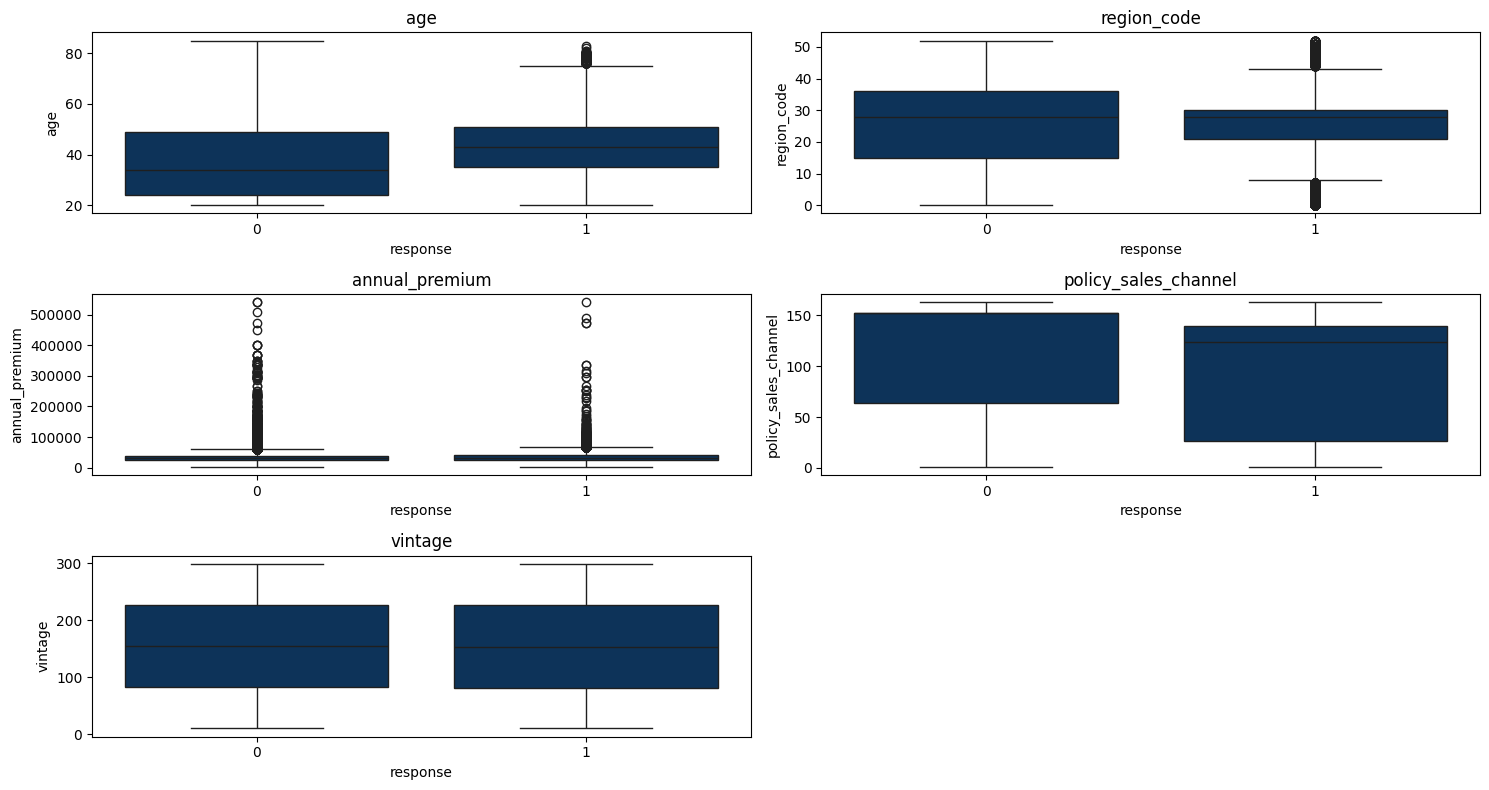

In [11]:
plt.figure(figsize=(15, 8))
for n, coluna in enumerate(df_number.columns, start=1):
    plt.subplot(3, 2, n)
    sns.boxplot(data=df1, x='response', y=coluna)
    plt.title(coluna)
    plt.tight_layout()


### 1.4.2 Atributos Categóricos 

In [12]:
df_object.apply(lambda x: x.unique())

gender                                 [Female, Male]
vehicle_age           [< 1 Year, 1-2 Year, > 2 Years]
vehicle_damage                              [No, Yes]
driving_license                                [1, 0]
previously_insured                             [1, 0]
response                                       [0, 1]
dtype: object

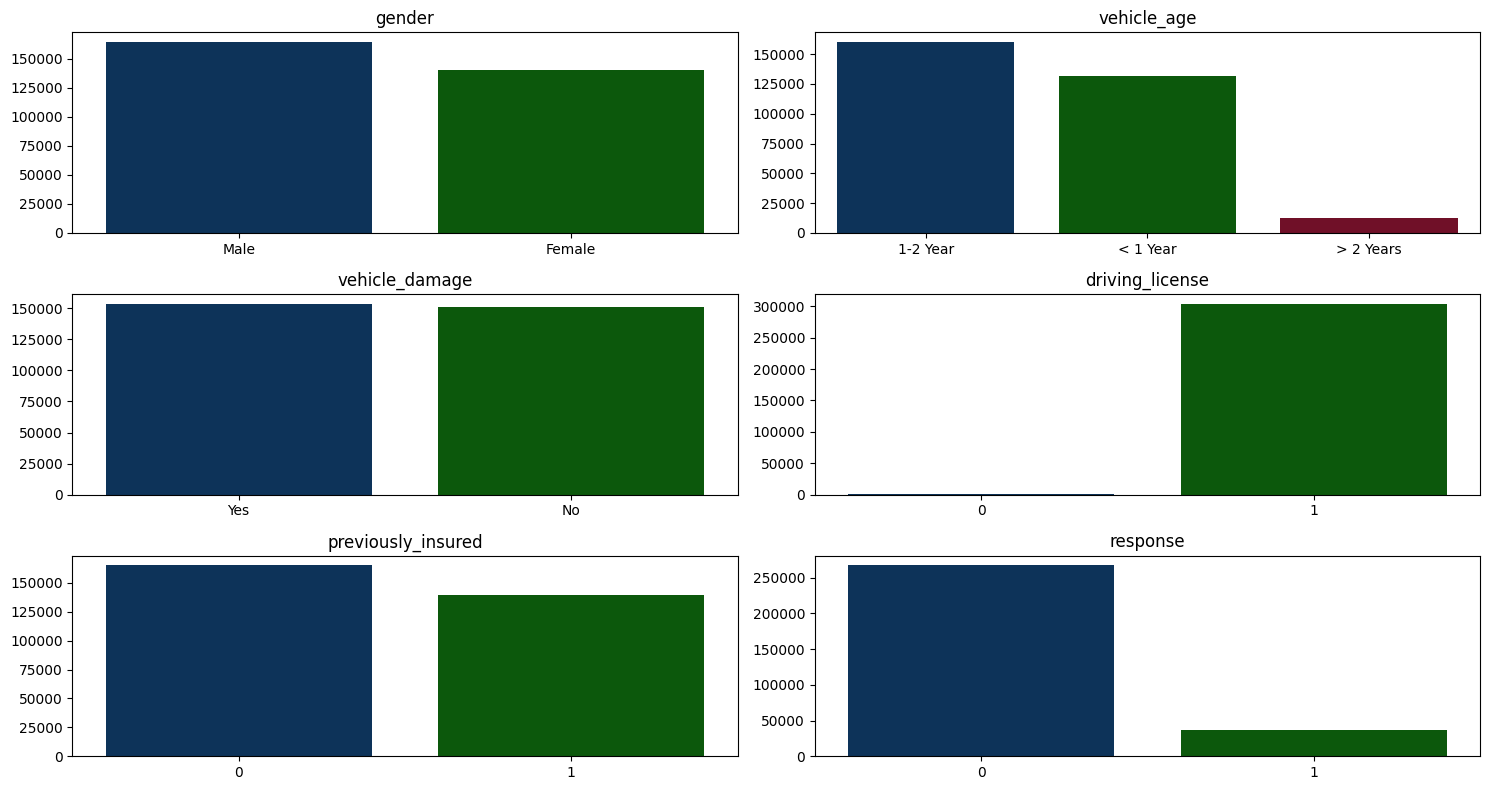

In [13]:
plt.figure(figsize=(15, 8))

for n, coluna in enumerate(df_object.columns, start=1):
    counts = df_object[coluna].value_counts()
    plt.subplot(3, 2, n) 
    sns.barplot( x=counts.index, y=counts.values, hue = counts.index)
    plt.xlabel('')
    plt.title(coluna)
    plt.legend([], frameon=False)
    plt.tight_layout()
    

#  2.0 Feature Engeneering

## 2.0.1 Negócio

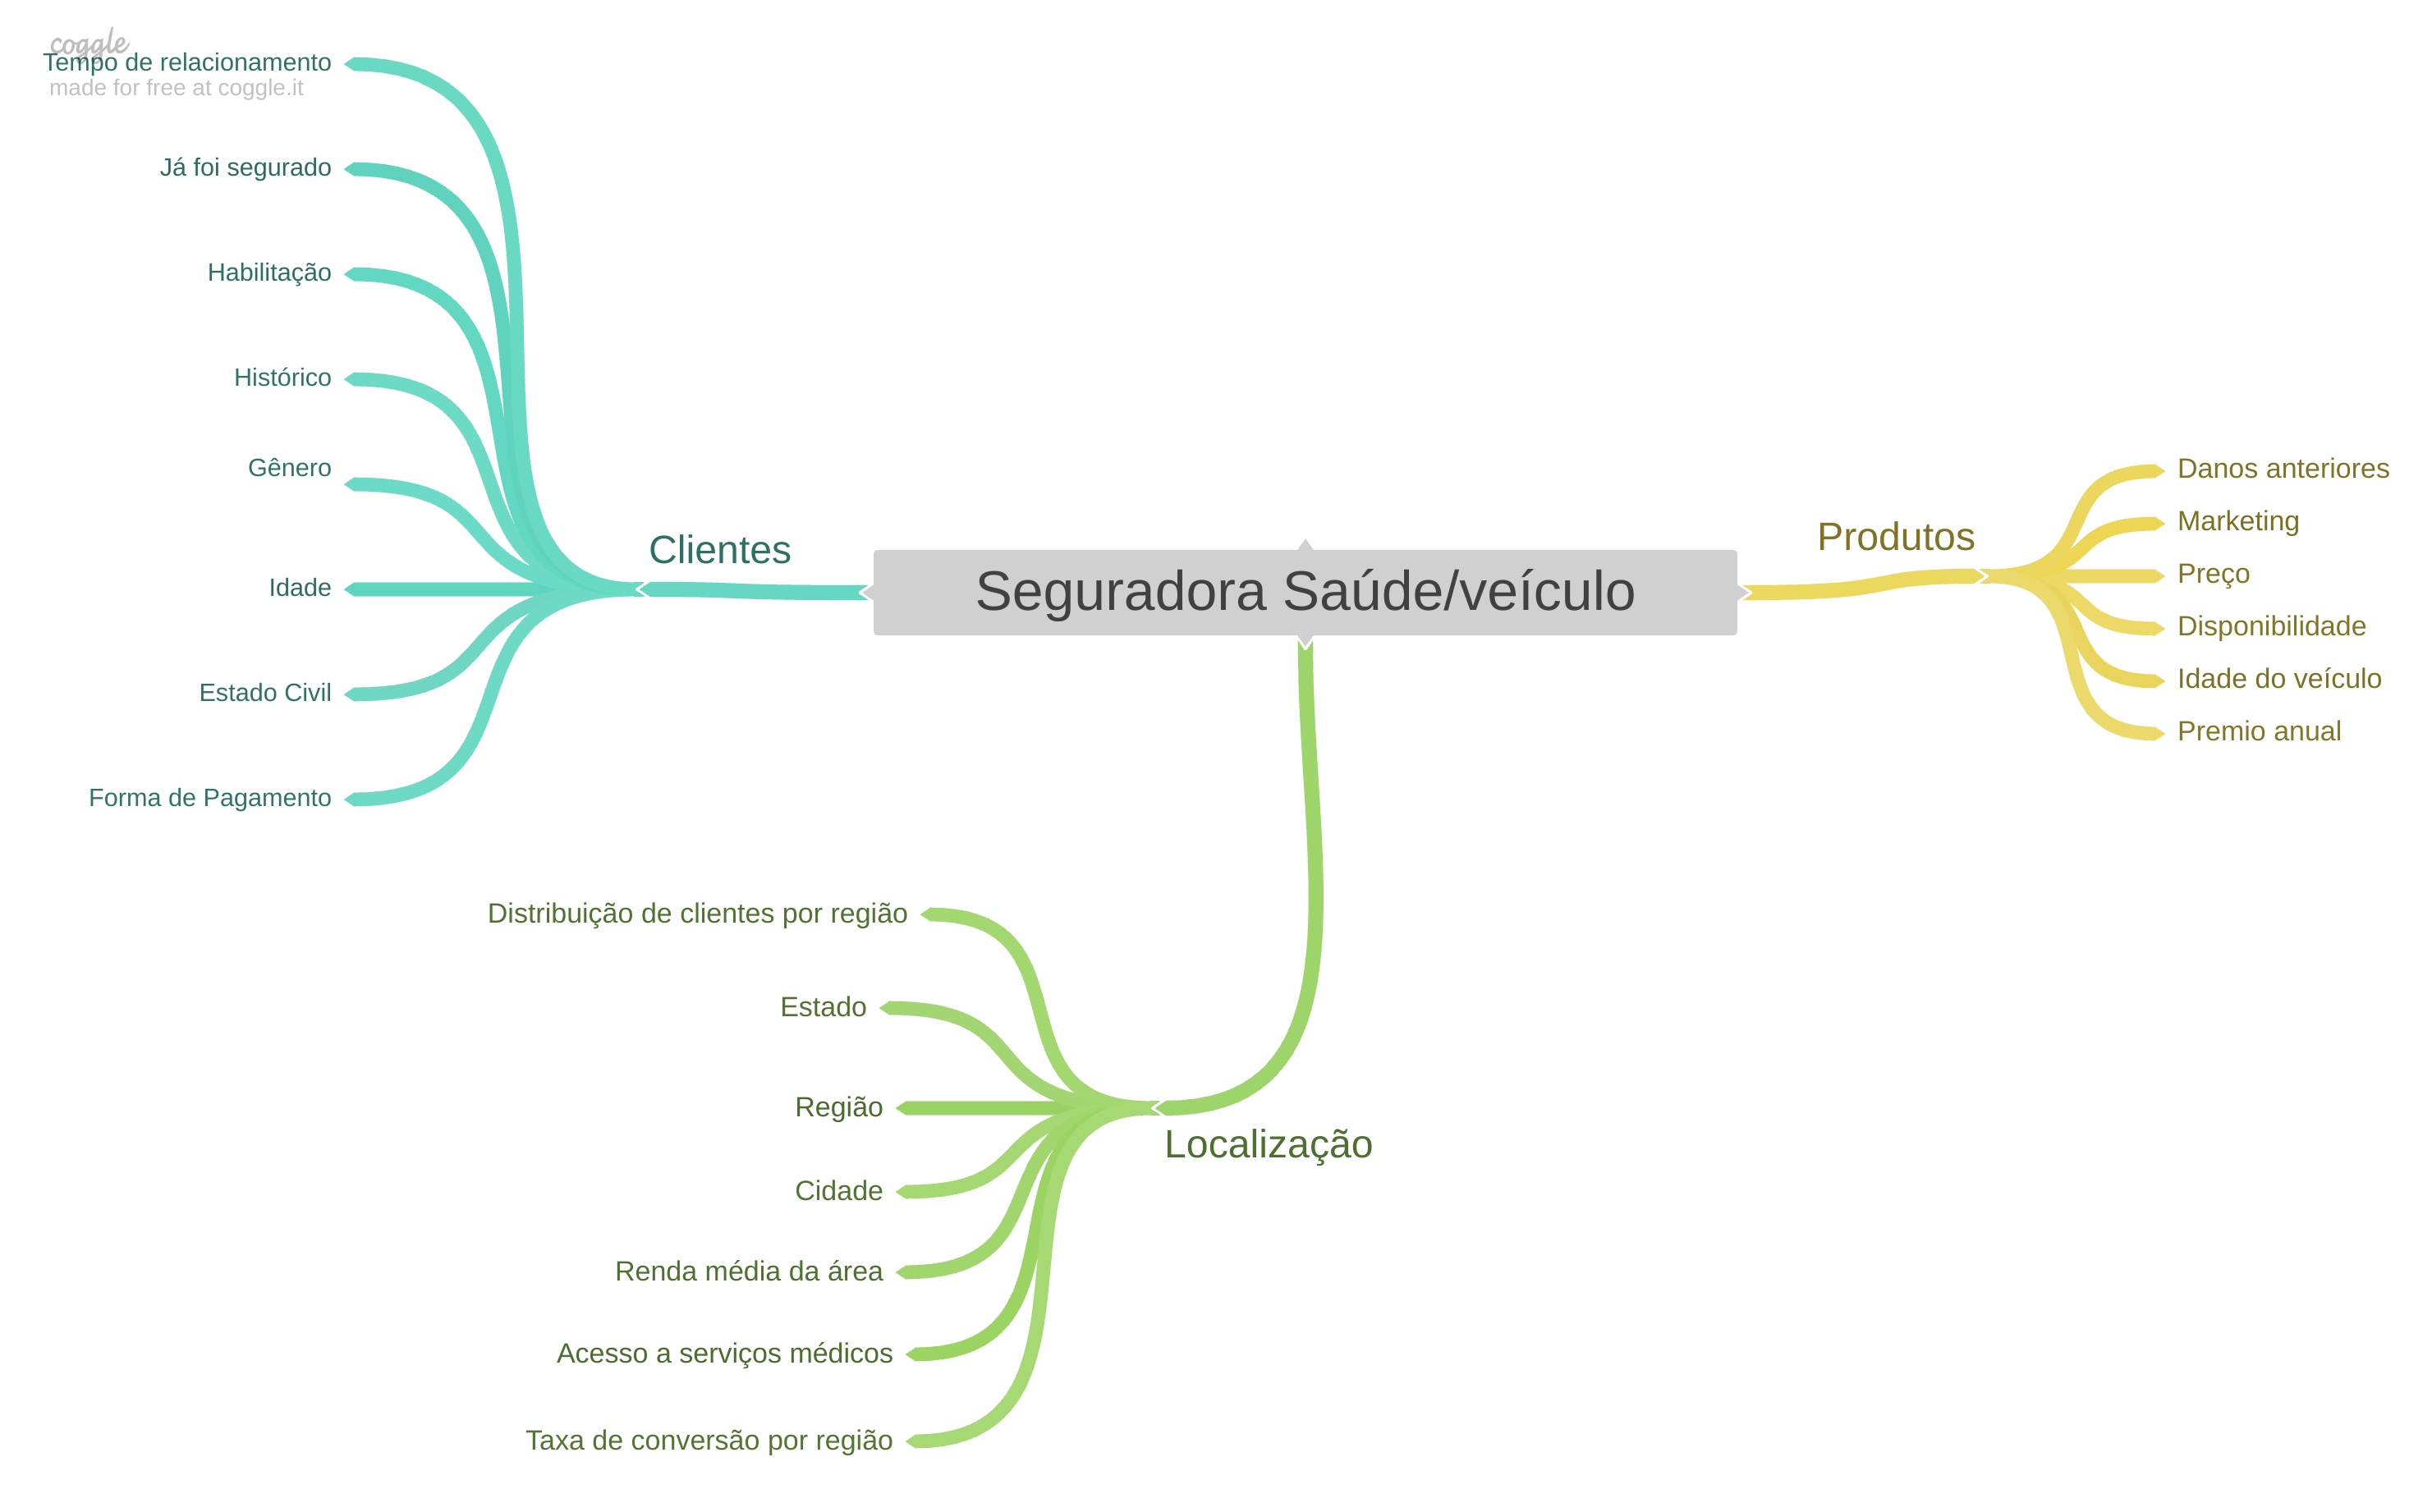

In [14]:
Image('img/img_seguradora.png')

## 2.1 Criação das Hipóteses

### 2.1.1 Hipóteses para Clientes

1. Clientes mais experientes (>=30 anos) têm maior propensão a contratar seguros para veículos pelo desejo de segurança.  

2. Clientes que já tiveram seguro anteriormente tem maior interesse em contratar o seguro.
3. Mulheres tem uma propenção maior para contratar seguros.
4. Clientes casados ou com filhos tendem a contratar seguros mais robustos devido à necessidade de proteção familiar.
5. Clientes com habilitação recente apresentam maior risco e, consequentemente, optam por planos básicos devido ao custo.


### 2.1.2 Hipóteses para Produtos

1. Clientes com veículos entre 1 e 2 anos são mais comumentes interessados no seguro.

2. Planos com preços acessíveis e benefícios extras, como assistência 24 horas, têm maior taxa de conversão.
3. Pessoas que já sofreram danos em veículos tem maior interesse em contratar o seguro.
4. A inclusão de seguros específicos para veículos elétricos ou híbridos pode atrair clientes com maior poder aquisitivo.
5. Pessoas que já tiveram seguro anteriormente tem maior interesse em contratar o seguro.


### 2.1.3 Hipóteses para Localização

1. Regiões com maior índice de roubos e furtos têm maior demanda por seguros com cobertura contra roubo.

2. Clientes em áreas urbanas têm maior adesão a seguros devido à maior exposição a acidentes.
3. Regiões com renda média mais alta têm maior interesse em seguros premium, com coberturas completas.
4. Cidades com menor acesso a serviços médicos ou oficinas têm maior interesse em seguros com benefícios de assistência em viagens.
5. Áreas com alto índice de acidentes de trânsito têm maior conversão em seguros com coberturas de danos a terceiros.

## 2.2 Top 8 Hipóteses  

1. Clientes mais experientes (>=30 anos) têm maior propensão a contratar seguros para veículos por procurar segurança.  

2. Clientes que já possuem um histórico de seguro têm maior probabilidade de se interessar pelo seguro. 

3. Mulheres tem maior propenção para contratar seguros, priorizando segurança.  

4. Clientes que já sofreram danos em veículos no passado têm maior chance de contratar seguros. 

5. Planos com preços mais acessíveis atraem clientes jovens ou com menor histórico de seguro. 

6. Clientes com mais ano de casa tem maior propenção de desejar o novo produto . 

7. Clientes com veículos mais novos são mais comumentes interessados no seguro. 

8. Clientes em regiões onde há maior proporção de veículos danificados têm maior probabilidade de contratar seguros.


## 2.3 Feature Engeneering

In [15]:
df2 = df1.copy()
df2.head(2)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
336707,336708,Female,23,1,30.0,1,< 1 Year,No,21620.0,152.0,138,0
193582,193583,Male,58,1,3.0,0,1-2 Year,Yes,2630.0,26.0,197,0


In [16]:
df2 = df1.copy()

# Separando clientes por custo do prêmio (categoria)
df2['premium_category'] = pd.cut(df2['annual_premium'],
                                 bins=[0, 10000, 30000, 50000, np.inf],
                                 labels=['Baixo\n(0:10000)', 'Médio\n(10000:30000)', 'Alto\n(30000:50000)', 'Muito Alto\n(50000:)'])

# # Separando clientes por custo do prêmio (valor)
# df2['premium_category_number'] = pd.cut(df2['annual_premium'],
#                                  bins=[0, 10000, 30000, 50000, np.inf],
#                                  labels=['(0:10000]', '(10000:30000]', '(30000:50000]', '(50000:)'])

# Separando grupos de clientes de acordo com o tempo de 'vintage' (dias)
df2['vintage_group'] = pd.cut(df2['vintage'], bins=[0, 60, 120, 240, np.inf], labels=['Recente\n(0:60)dias', 'Intermediário\n(60:120)', 'Longo\n(120:240)', 'Muito Longo\n(240:)'])


damage = df2.loc[df2['vehicle_damage']=='Yes',['id','region_code']].groupby('region_code').agg({'id':'count'})
total = pd.DataFrame(df2.groupby(['region_code'])['id'].count())
merged = damage.merge(total, on= 'region_code')
merged.columns = ['veiculos_danificados_regiao', 'total_veiculos_regiao']
merged['pct_damage_region'] = ((merged['veiculos_danificados_regiao']/merged['total_veiculos_regiao'])*100).astype(int)

df2 = pd.merge(df2, merged, on= 'region_code', how='left') 


# 3 - EDA (Análise Exploratória de Dados)

## 3.1 Análise Univariada

### 3.1.1 Variavel Responsta

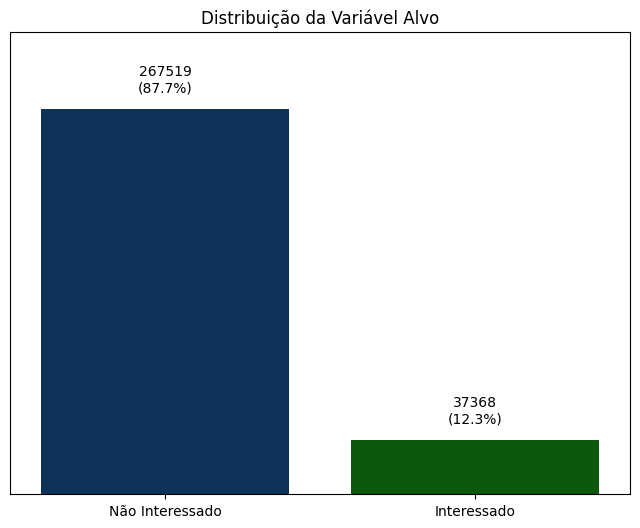

In [17]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df1, x='response', hue='response', dodge=False)

ax.legend([], [], frameon=False)
ax.yaxis.set_visible(False)

plt.xticks(ticks=[0, 1], labels=['Não Interessado', 'Interessado'])
plt.xlabel('')
plt.title('Distribuição da Variável Alvo')

plt.ylim(0, df1['response'].value_counts().max() * 1.2)

total = len(df1)
category_counts = df1['response'].value_counts()

for index, category in enumerate(category_counts.index):
    count = category_counts[category] 
    percentage = 100 * count / total 
    x = index 
    y = count +10000
    ax.text(x, y, f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=10)

plt.show()


- Como há um desbalanceamento de classes e o objetívo é encontrar os clientes com a maior propensão de compra utilizarei a métrica Precision para identificar os acertos na classe de interesse.

### 3.1.2 Distribuições das Variáveis Numéricas

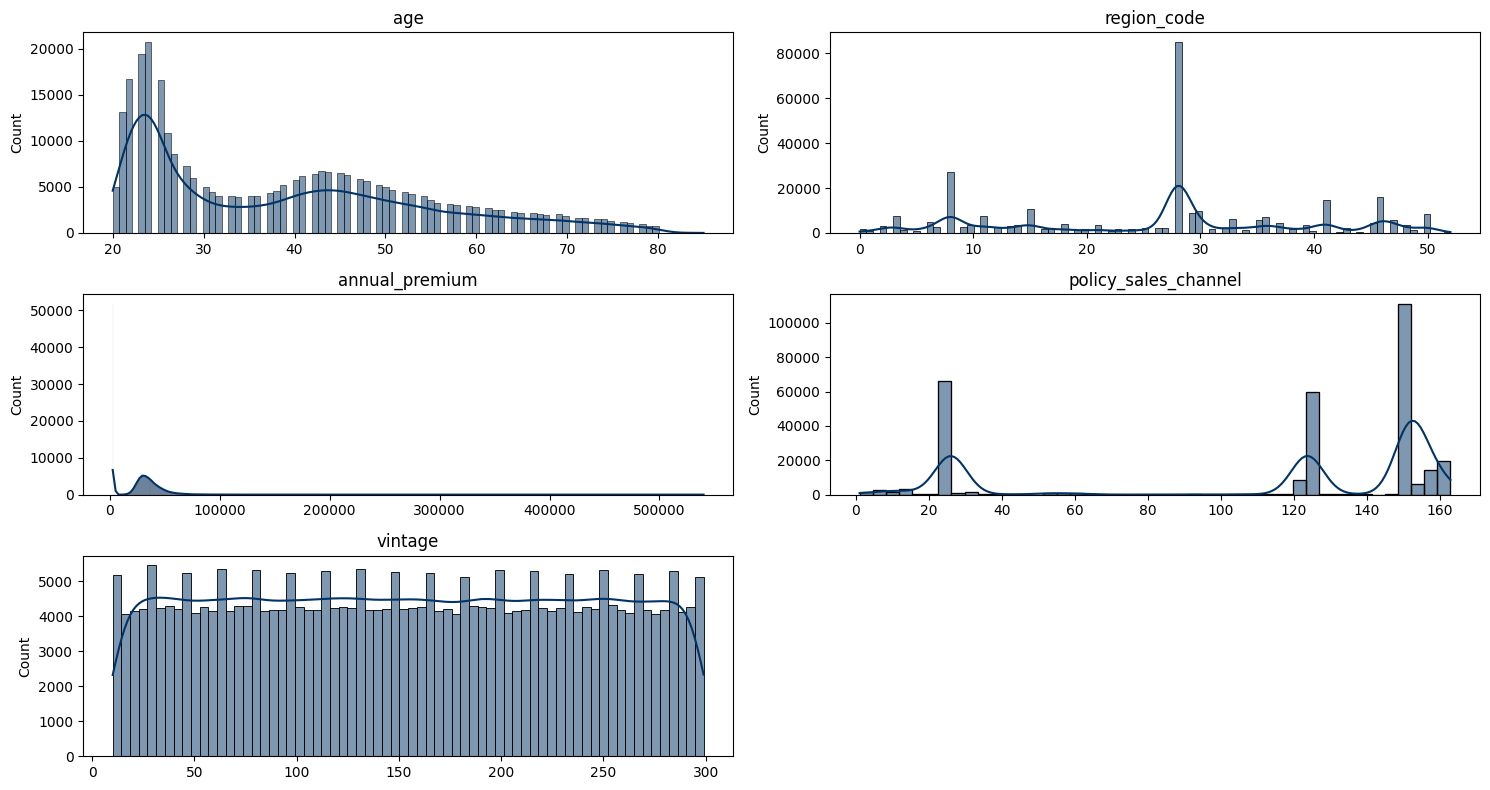

In [18]:
plt.figure(figsize=(15, 8))
for n, coluna in enumerate(df_number.columns, start=1):
    plt.subplot(3, 2, n)  
    sns.histplot(data=df_number, x=coluna, kde=True)
    plt.title(coluna)
    plt.xlabel('')
    plt.tight_layout()


- A distribuição de 'age' está mais concentrada em jovens de 20 a 25 anos, é uma ótima oportunidade de gerar uma relação duradoura e lucrativa com o cliente.
- As demais variaveis necessitam de uma análise mais aprofundada  

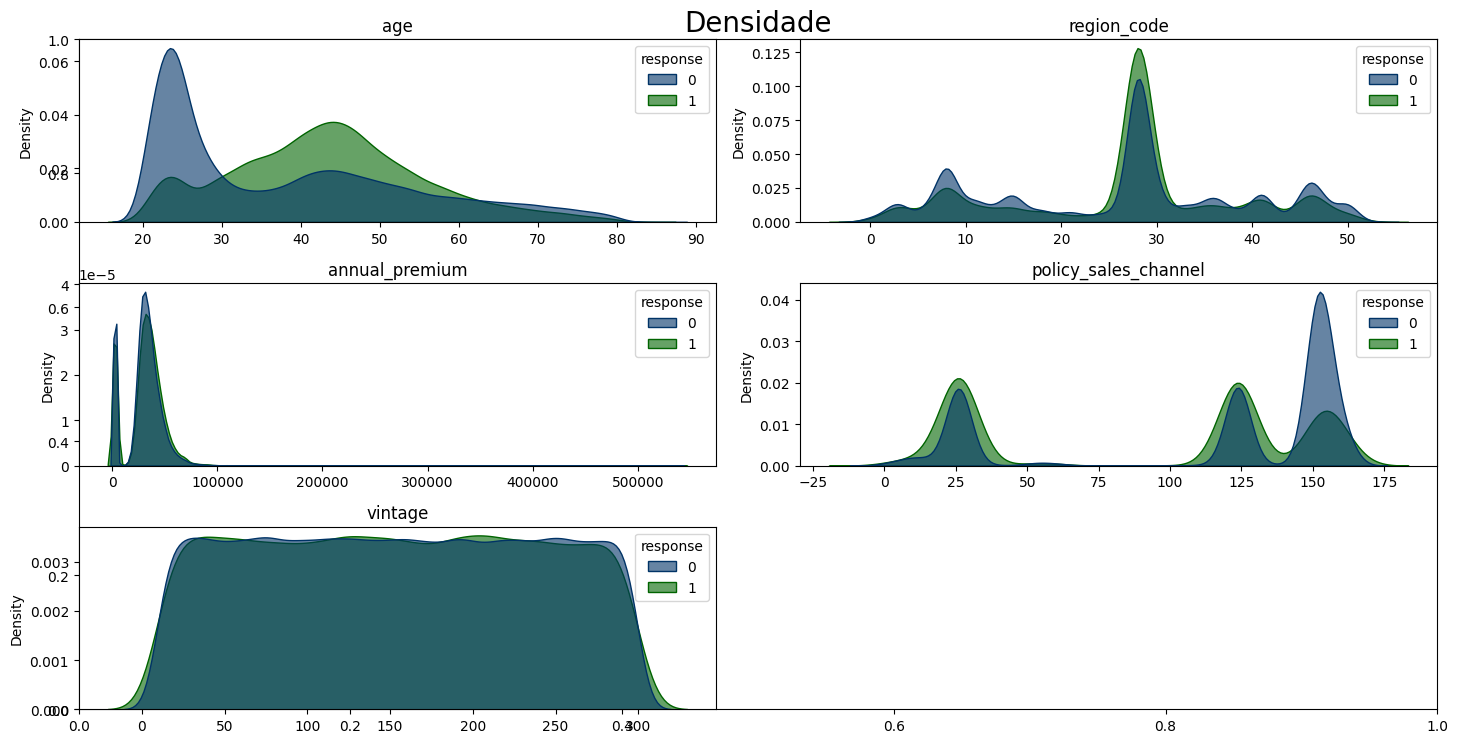

In [19]:
df_combined = df_number.copy()
df_combined['response'] = df1['response']
# df_combined = df_combined.loc[df_combined['annual_premium']<80000,:]

plt.figure(figsize=(15, 8))
plt.title('Densidade',size = 20)
for n, coluna in enumerate(df_number.columns, start=1):
    plt.subplot(3, 2, n)  
    sns.kdeplot(data=df_combined, x=coluna, hue='response', fill=True, common_norm=False, alpha=0.6)
    plt.title(coluna)
    plt.xlabel('')
    plt.tight_layout()

- Novamente 'age' chama atenção, porém demonstrando que clientes mais jovens tem um menor interesse em seguro de veículos. Essa informação será de grande valor para o modelo.
- Outras variaveis tambem demonstram um certo comportamento mas bem menos perceptivo.

### 3.1.3 Distribuição das Variáveis categóricas

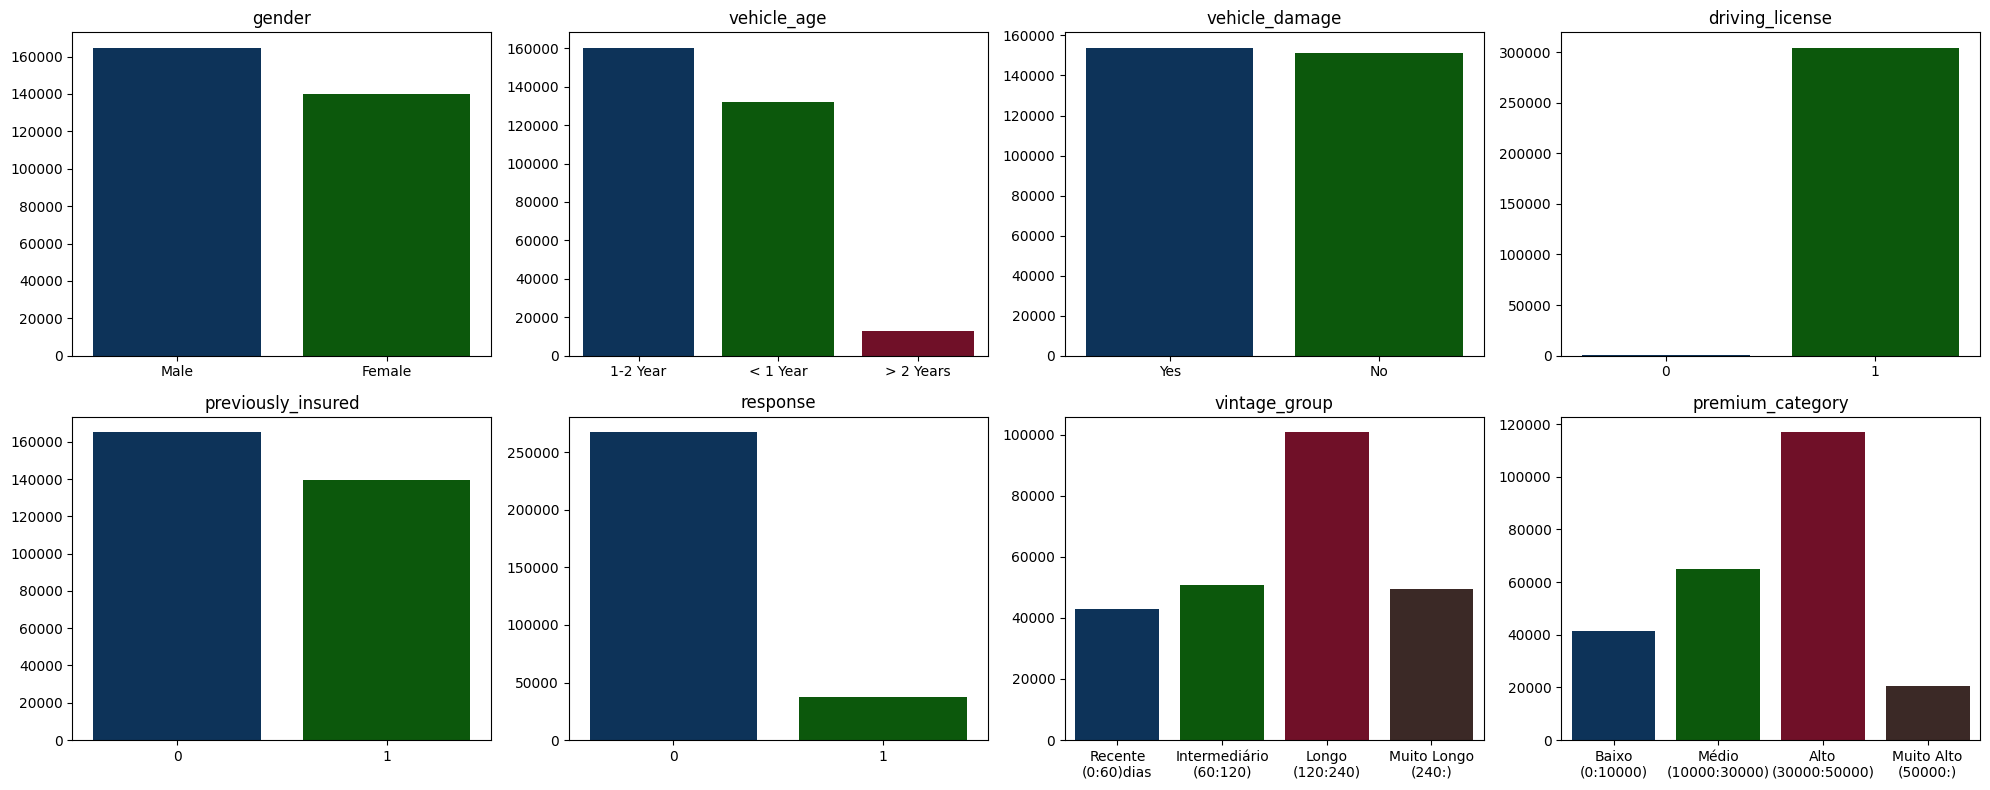

In [20]:
plt.figure(figsize=(20, 8))
df_object['vintage_group'] = df2['vintage_group']
df_object['premium_category'] = df2['premium_category']

for n, coluna in enumerate(df_object.columns, start=1):
    counts = df_object[coluna].value_counts()
    plt.subplot(2, 4, n) 
    sns.barplot( x=counts.index, y=counts.values, hue = counts.index)
    plt.xlabel('')
    plt.title(coluna)
    plt.legend([], frameon=False)
    plt.tight_layout()
    
    

## 3.2 Analise Bivariada

### 3.2.1 Distribuição de variaveis por categoria e por interesse no produto

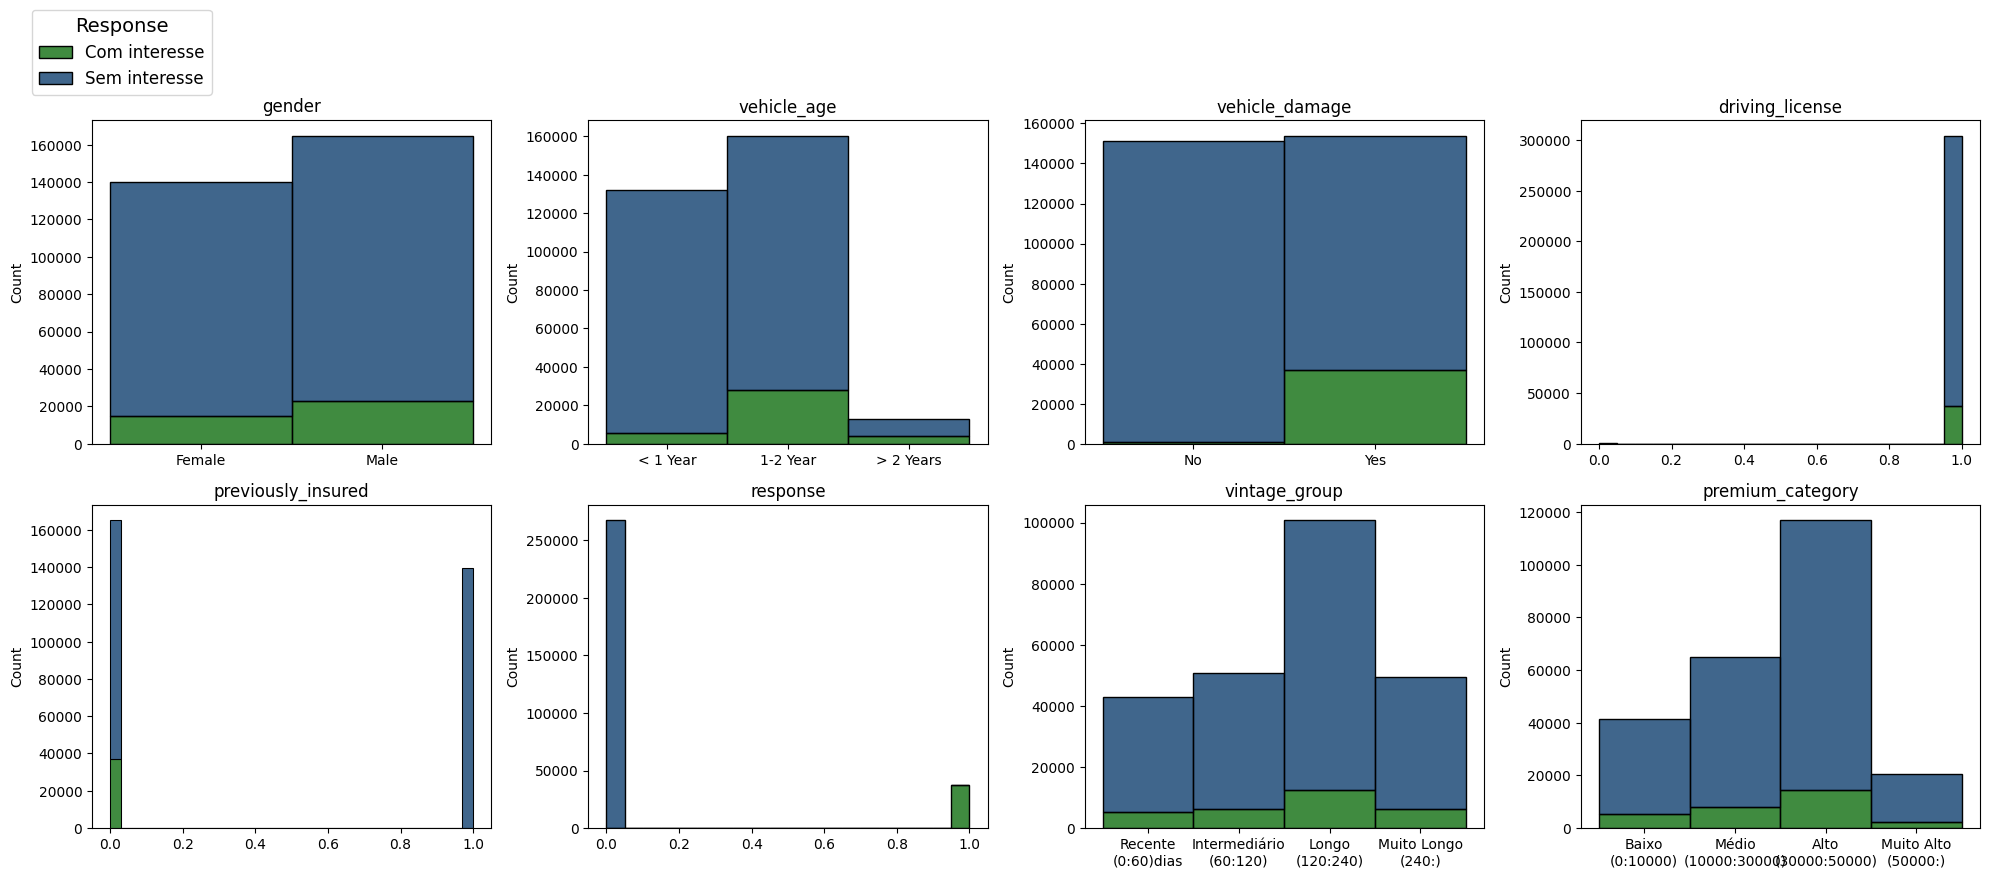

In [21]:
plt.figure(figsize=(20, 8))
for n, coluna in enumerate(df_object.columns, start=1): 
    plt.subplot(2, 4, n)
    sns.histplot(data=df_object, x=coluna, hue="response", multiple="stack")
    plt.title(coluna)
    plt.xlabel('')
    plt.legend([], frameon=False)
    plt.tight_layout()

plt.legend(
        title="Response",
        title_fontsize=14, fontsize=12, 
        labels=['Com interesse','Sem interesse'],
        loc="center left",
        bbox_to_anchor=(-3.9, 2.4))

plt.show()

- Clientes com veículos entre 1 e 2 anos são mais comumentes interessados no seguro.
- Pessoas que já sofreram danos em veículos tem maior interesse em contratar o seguro.
- Não existem ou existem muito poucas pessoas sem carteira de motorista na base de dados.
- Pessoas que já possuem seguro não tem interesse em contratar o seguro.

In [22]:
df_object['driving_license'].value_counts()

driving_license
1    304246
0       641
Name: count, dtype: int64

### 3.2.2 Validação de Hipóteses

#### H1. Clientes mais experientes (>=30 anos) têm maior propensão a contratar seguros para veículos por procurar segurança.  
**Verdadeira** Entre as faixas de 30 a 55 anos a porcentagem de interessse é proxima aos 20%

bloco_idade
(20, 25]    86719
(25, 30]    37569
(30, 35]    20313
(35, 40]    23914
Name: id, dtype: int64

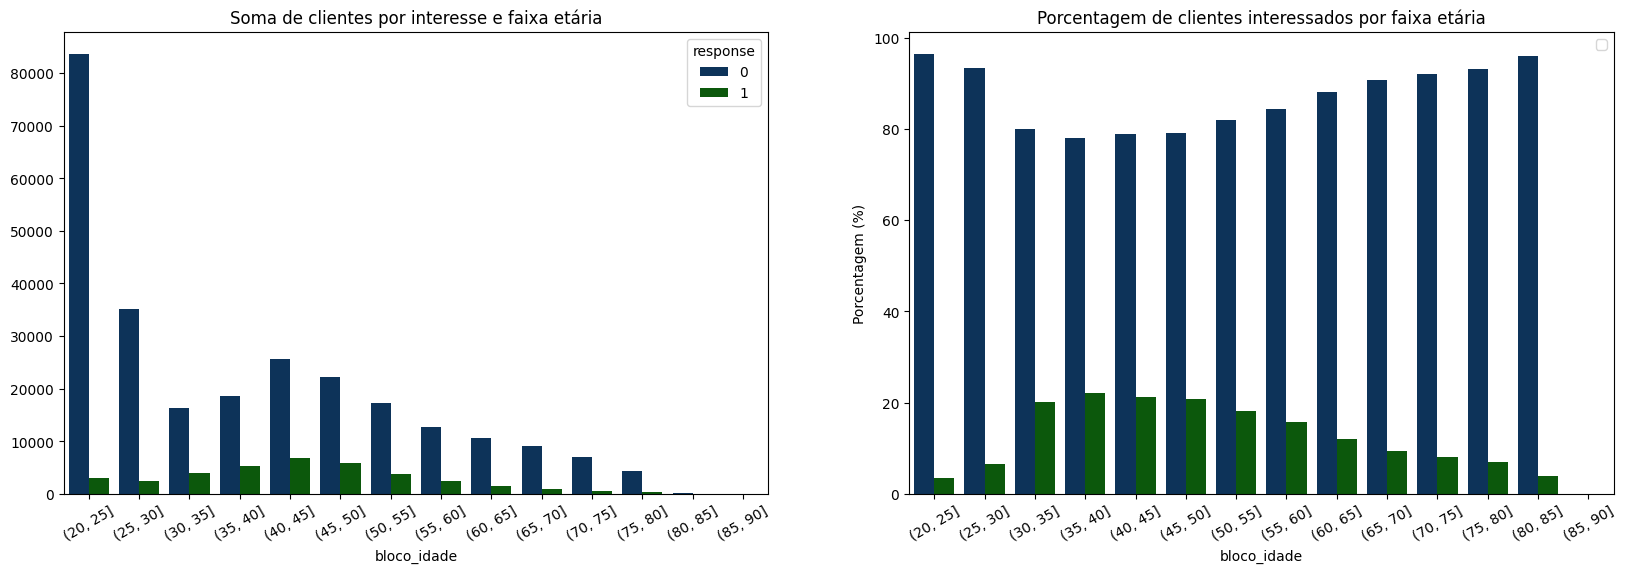

In [23]:
aux1 = df2.copy()
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
bins = list(range(20,91,5))
aux1['bloco_idade'] = pd.cut(aux1['age'],bins=bins)
aux2 = aux1.loc[:,['id','bloco_idade', 'response']].groupby(['bloco_idade','response'],observed=False).count().reset_index()
sns.barplot(data = aux2, x='bloco_idade', y= "id",hue='response')
plt.ylabel('')
plt.xticks(rotation = 30);
plt.title('Soma de clientes por interesse e faixa etária');

plt.subplot(1,2,2)
plt.title('Porcentagem de clientes interessados por faixa etária')
bins = list(range(20,91,5))
aux1['bloco_idade'] = pd.cut(aux1['age'],bins=bins)
aux3 = aux1.loc[:,['id','bloco_idade', 'response']].groupby(['bloco_idade','response'],observed=False).count().reset_index()
total_por_faixa = aux3.groupby('bloco_idade',observed=False)['id'].sum()
total_por_faixa_categoria = aux3.groupby(['bloco_idade', 'response'],observed=False)['id'].sum()
porcentagem_categoria = (total_por_faixa_categoria / total_por_faixa) * 100
aux3 = pd.DataFrame(porcentagem_categoria)
sns.barplot(data = aux3, x='bloco_idade', y= "id",hue='response')
plt.legend([])
plt.xticks(rotation = 30);
plt.ylabel('Porcentagem (%)');
total_por_faixa.head(4)

#### H2. Clientes que já possuem um histórico de seguro têm maior probabilidade de se interessar pelo seguro. 
**Falsa** Clientes que já possuem seguro para veículo não tem interesse.

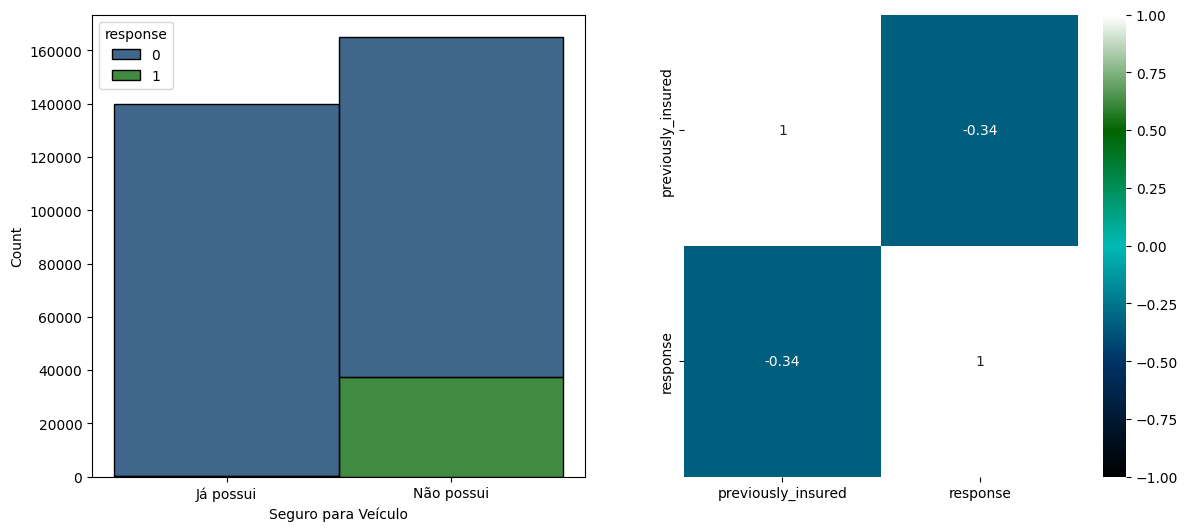

In [24]:
plt.figure(figsize =(14,6))

dfaux1 = df2.copy()
dfaux1['previously_insured'] = df2['previously_insured'].map(lambda x: 'Já possui' if x==1 else 'Não possui')
plt.subplot(1,2,1)
sns.histplot(data = dfaux1, x= 'previously_insured',hue = 'response',multiple='stack')
plt.xlabel('Seguro para Veículo')

plt.subplot(1,2,2)
dfaux = df2[['previously_insured','response']]

from matplotlib.colors import LinearSegmentedColormap
# Paleta de cores para headmap
custom_palette = ['#000000','#003366','#00bab4', '#006400','#FFFFFF']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', custom_palette)

sns.heatmap(dfaux.corr(method='pearson'), annot=True, vmin=-1, vmax=1, cmap=custom_cmap);

#### H3. Mulheres tem maior propenção para contratar seguros, priorizando segurança. 
**Falsa** O gênero pouca ou nenhuma correlação com a propenção de interesse no seguro para veículo, apenas 5% maior para homens.

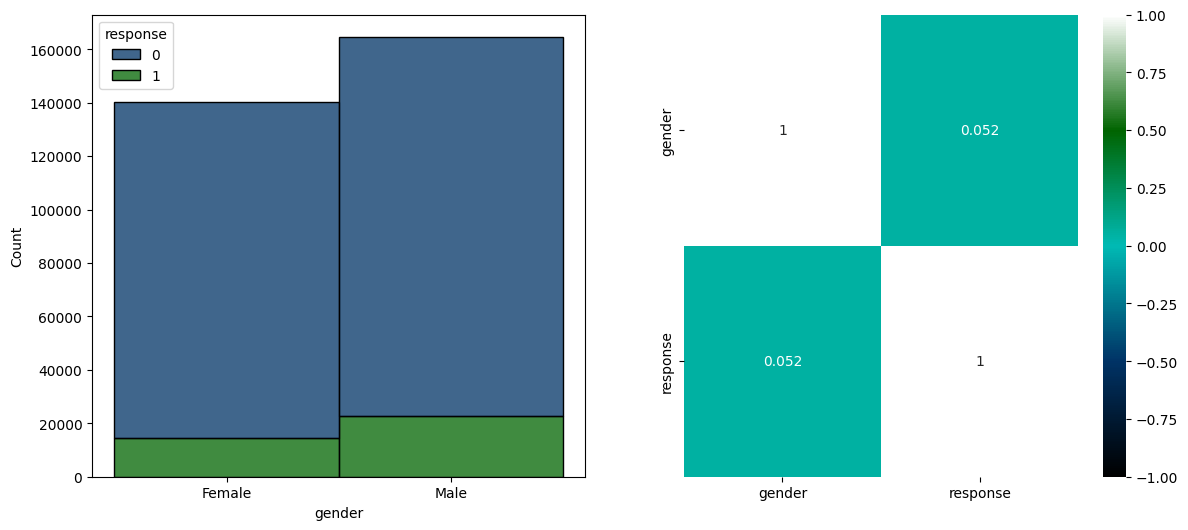

In [25]:
plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
sns.histplot(data = dfaux1, x= 'gender',hue = 'response',multiple='stack')

plt.subplot(1,2,2)
dfaux = df2[['gender','response']].copy()
dfaux['gender'] = dfaux['gender'].map(lambda x: 1 if x=='Male' else 0)
sns.heatmap(dfaux.corr(method='pearson'), annot = True, vmin=-1, vmax=1, cmap = custom_cmap);

#### H4. Clientes que já sofreram danos em veículos no passado têm maior chance de contratar seguros. 
**Verdadeira** Clientes que já sofreram danos em seus veículos tem maiores chances de contratar o seguro. 

In [26]:
dfaux1['vehicle_damage'].value_counts()

vehicle_damage
Yes    153862
No     151025
Name: count, dtype: int64

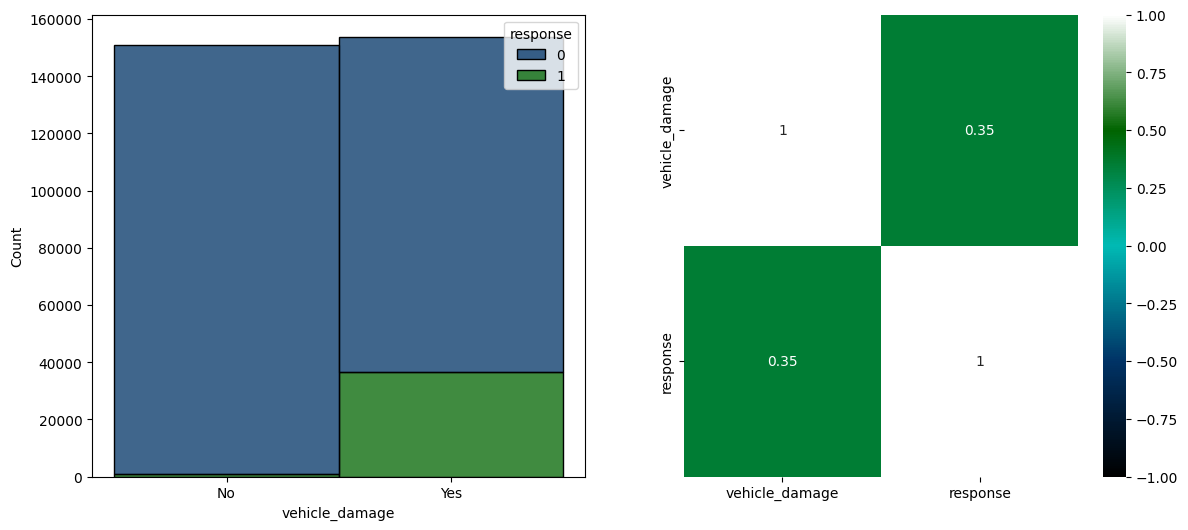

In [27]:
plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
sns.histplot(data = dfaux1, x= 'vehicle_damage',hue = 'response', multiple = 'stack')

plt.subplot(1,2,2)
dfaux = df2[['vehicle_damage','response']].copy()
dfaux['vehicle_damage'] = dfaux['vehicle_damage'].map(lambda x: 1 if x=='Yes' else 0)
aux1 = dfaux.corr(method='pearson')
sns.heatmap(aux1, annot = True, vmin=-1, vmax=1, cmap = custom_cmap);

#### H5. Planos com preços mais acessíveis atraem clientes jovens ou com menor histórico de seguro. 
**Falsa** Clientes jevens além de pouco interesse por seguros preferem seguros de preços 'Altos' ou 'Médios'

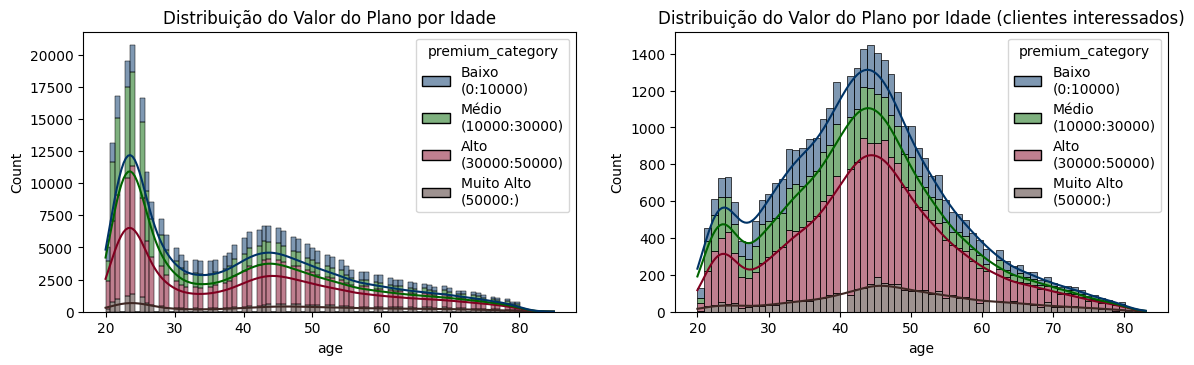

In [28]:
# sns.scatterplot(data = df2[:500], x='age', y='annual_premium', hue = 'response')
aux = df2.copy()
plt.figure(figsize = (14,8))

plt.subplot(2,2,1)

plt.title('Distribuição do Valor do Plano por Idade')
sns.histplot(data=aux, x='age', hue='premium_category', kde=True, multiple='stack')

plt.subplot(2,2,2)
plt.title('Distribuição do Valor do Plano por Idade (clientes interessados)')
aux1 = aux[aux['response']==1]
sns.histplot(data=aux1, x='age', hue='premium_category', kde=True, multiple='stack');



#### H6. Clientes com mais tempo de casa tem maior propenção de desejar o novo produto. 
**Falsa** Não há correlação entre o tempo e o interesse no seguro.

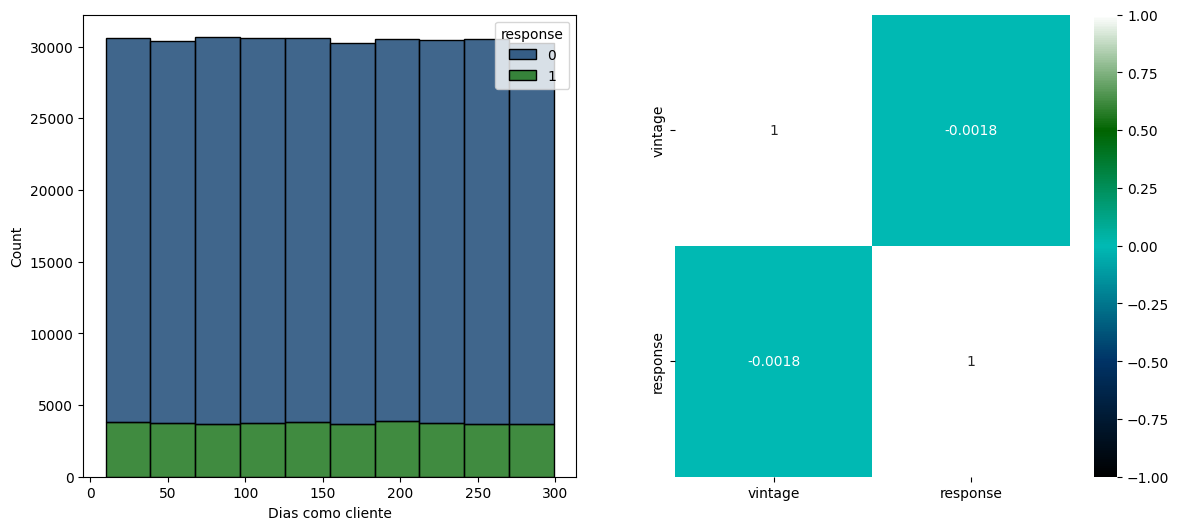

In [29]:
plt.figure(figsize=(14,6))
# aux = df2[df2['response']==1]
plt.subplot(1,2,1)
sns.histplot(data=aux, x='vintage', hue='response', multiple='stack', bins = 10)

plt.xlabel('Dias como cliente')
plt.subplot(1,2,2)
aux = df2[['vintage','response']]
aux1 = aux.corr(method='pearson')
sns.heatmap(aux1, annot = True, vmin=-1, vmax=1, cmap = custom_cmap);

#### H7. Clientes com veículos mais novos são mais comumentes interessados no seguro. 
**Verdadeira** A maior parte dos clentes interessados tem veículos novos. Porém os com veículos com mais de 2 anos tem uma porcentagem de interesse maior.

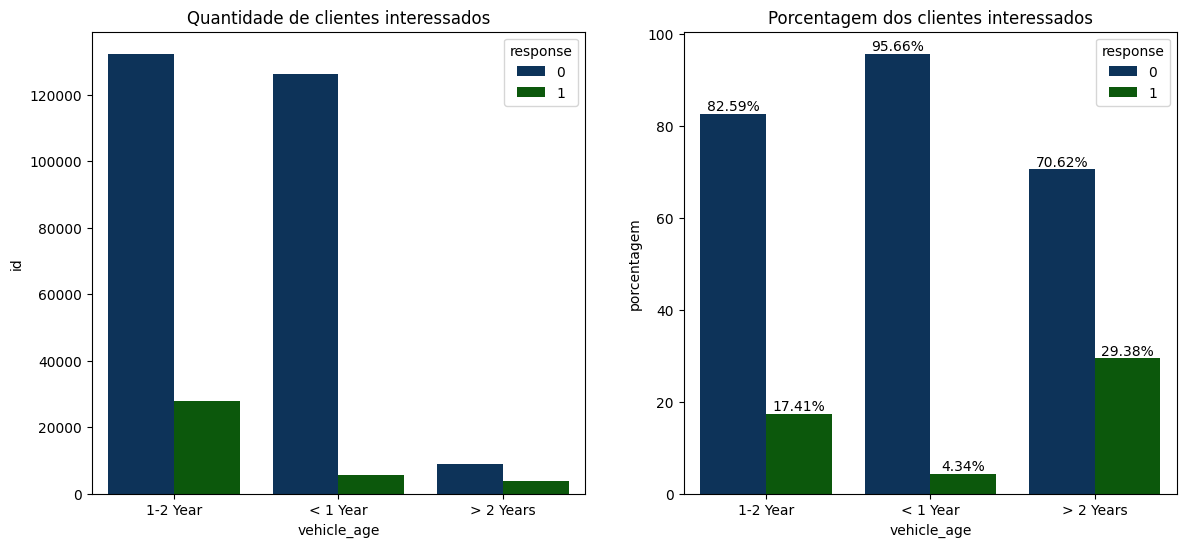

In [30]:
plt.figure(figsize = (14,6))

plt.subplot(1,2,1)
aux = df2.loc[:,['id', 'vehicle_age','response']].groupby(['vehicle_age', 'response']).count().reset_index()
sns.barplot(data = aux, x= 'vehicle_age', y='id', hue='response', estimator="sum")
plt.title('Quantidade de clientes interessados')


plt.subplot(1,2,2)
aux1 = df2.loc[:,['id', 'vehicle_age','response']].groupby(['vehicle_age', 'response']).count().reset_index()
aux1['porcentagem'] = aux1.groupby('vehicle_age')['id'].transform(lambda x: x/x.sum() * 100)

ax = sns.barplot(data = aux1, x= 'vehicle_age', y='porcentagem', hue='response')

for container in ax.containers:
    labels = [f"{v.get_height():.2f}%" for v in container]  
    ax.bar_label(container, labels=labels, fontsize=10)
plt.title('Porcentagem dos clientes interessados');


#### H8. Clientes em regiões onde há maior proporção de veículos danificados têm maior probabilidade de contratar seguros.
**Verdadeira** Clientes em regiões onde a porcentagem de veículos que já foram danificados é relevante tem uma maior propenção a desejar um seguro.

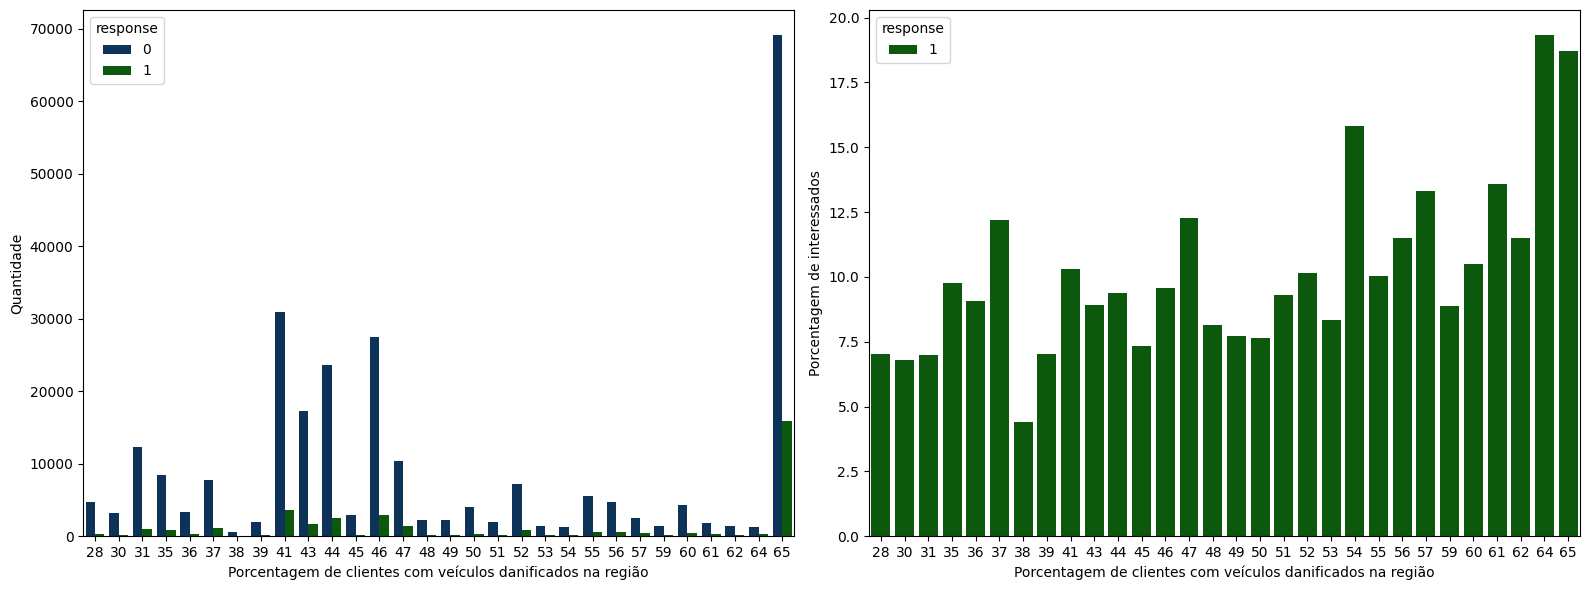

In [40]:
aux =df2[['pct_damage_region','response']].groupby(['pct_damage_region','response']).agg({'response':'count'})
aux.columns = ['count']
aux = aux.reset_index()

total_por_faixa = aux.groupby('pct_damage_region',observed=False)['count'].sum()
total_por_faixa_categoria = aux.groupby(['pct_damage_region', 'response'],observed=False)['count'].sum()
porcentagem_categoria = pd.DataFrame((total_por_faixa_categoria/ total_por_faixa)*100).reset_index()
aux['pct_response'] = porcentagem_categoria['count']
aux.head(4)

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.title('')
sns.barplot(x='pct_damage_region', y= 'count', data=aux, hue = 'response', errorbar = None)
plt.xlabel('Porcentagem de clientes com veículos danificados na região')
plt.ylabel('Quantidade')

plt.subplot(1,2,2)

sns.barplot(x='pct_damage_region', y='pct_response', data=aux[aux['response'] == 1], hue='response', palette=['#006400'])


plt.xlabel('Porcentagem de clientes com veículos danificados na região')
plt.ylabel('Porcentagem de interessados')

plt.tight_layout()

## 3.3 Analise Multivariada

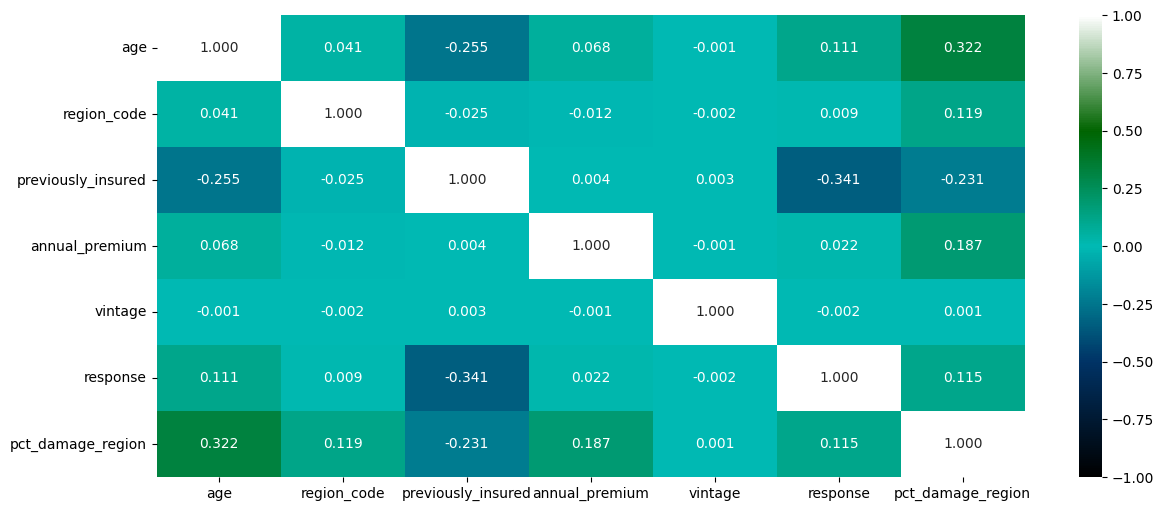

In [120]:
df_number = df2.select_dtypes(include = ['int64', 'float64', 'int32'])
df_number = df_number[['age', 'region_code','previously_insured','annual_premium','vintage','response','pct_damage_region']]

correlation = df_number.corr(method = 'pearson')
plt.figure(figsize = (14,6))
sns.heatmap(data = correlation, annot=True, vmin=-1, vmax=1, cmap=custom_cmap,fmt='.3f',);

## 3.4 Principais Insigths

- #### 1. Se a região do cliente possui alta taxa de clientes com veículos danificados a chance dele querer um seguro é maior.
- #### 2. Clientes com veículos entre 1 e 2 anos são mais comumentes interessados no seguro.
- #### 3. Pessoas que já sofreram danos em veículos tem maior interesse em contratar o seguro.
- #### 4. Pessoas que já possuem seguro não tem interesse em contratar o seguro.
- #### 5. O gênero do cliente não possui relevância.
- #### 6. O tempo de relacionamento com o cliente não tem relevância.
- #### 7. Clientes com mais de 30 anos tem um maior interesse no seguro.

# 4 - Pré-processamento dos dados

In [47]:
def transform(aux, columns, columns_scaler):
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    aux = aux[columns].copy()
    aux['vehicle_age'] = aux['vehicle_age'].map(lambda x: 1 if x=='< 1 Year' else 2 if x=='1-2 Year' else 3)
    aux['vehicle_damage'] = aux['vehicle_damage'].transform(lambda x: 1 if x=='Yes' else 0)
        
    aux[columns_scaler] = scaler.fit_transform(aux[columns_scaler])
    aux['age'] = aux['age'].transform(lambda x: x**2+x)      
    
    aux = np.array(aux)
    
    return aux
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,premium_category,vintage_group,veiculos_danificados_regiao,total_veiculos_regiao,pct_damage_region
0,336708,Female,23,1,30.0,1,< 1 Year,No,21620.0,152.0,138,0,Médio\n(10000:30000),Longo\n(120:240),3107,9799,31
1,193583,Male,58,1,3.0,0,1-2 Year,Yes,2630.0,26.0,197,0,Baixo\n(0:10000),Longo\n(120:240),3514,7359,47
2,170386,Female,24,1,28.0,0,< 1 Year,Yes,47596.0,152.0,53,0,Alto\n(30000:50000),Recente\n(0:60)dias,56028,85023,65
3,188913,Male,21,1,30.0,0,< 1 Year,Yes,25642.0,152.0,136,0,Médio\n(10000:30000),Longo\n(120:240),3107,9799,31
4,130088,Female,31,1,2.0,1,< 1 Year,No,32465.0,152.0,96,0,Alto\n(30000:50000),Intermediário\n(60:120),1451,3221,45


In [57]:
X = df2.drop(columns = ['response'])
y = df2['response']

# x_train, x_val, y_train, y_val =  ms.train_test_split(x_raw, y_raw, test_size = 0.2, stratify=df2['response'], random_state = 12)
columns = ['age','previously_insured','vehicle_damage','vehicle_age','driving_license','annual_premium','pct_damage_region']

columns_scaler = ['age','previously_insured','vehicle_damage','vehicle_age','annual_premium','pct_damage_region']

X = transform(X, columns = columns, columns_scaler = columns_scaler)

# 5.0 Machine Learning Modeling

In [ ]:
X[0:3]

## 5.1 Models cross validation

In [58]:
# Modelo
model = RandomForestClassifier(random_state=42)

# Cross-validation com precision como métrica
scores = cross_val_score(model, X, y, cv=5, scoring='precision')

# Resultados
print("Precision por fold:", scores)
print("Média da precision:", scores.mean())
print("Desvio padrão da precision:", scores.std())


Precision por fold: [0.30644298 0.30083515 0.30390368 0.29764533 0.29891304]
Média da precision: 0.30154803631249427
Desvio padrão da precision: 0.003230853016346375


## 2.2 Modelagem 

In [54]:
# define 
model = LogisticRegression(max_iter=200)

# training
model.fit(X, y)

# performance
# yhat_val = model.predict(x_val)

NameError: name 'x_val' is not defined

## 2.3 Performance

## Roc Curve

In [53]:

yhat_val = model.predict_proba(x_val)
yhat_val = yhat_val[:,1]
# Calculando os pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_val, yhat_val)
roc_auc = auc(fpr, tpr)


th = 0.29

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(thresholds, tpr, 'g--', label = 'TPR')
plt.plot(thresholds, 1-fpr, 'b-', label = 'FPR')
plt.legend(['True Positive', 'False Positive'])
plt.vlines(th, 0, 1)

y_pred = [1 if i > th else 0 for i in yhat_val]
cm = mt.confusion_matrix(y_val, y_pred)

plt.subplot(1,2,2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()
f1 = mt.f1_score(y_val, y_pred)
print(f'F1 Score = {f1}')

precision = mt.precision_score(y_val, y_pred)
print(f"Precision: {precision}")

NameError: name 'x_val' is not defined

r1 =    F1 Score = 0.3727963208138806
        Precision: 0.2465892330383481

r2 =    F1 Score = 0.38746650175221603
        Precision: 0.27242158965737145


r3 =    F1 Score = 0.3205539358600583
        Precision: 0.32752457551385167





F1 Score = 0.3217618514371034

Precision: 0.26777862741349645

F1 Score = 0.10899625833740036

Precision: 0.12627214474180173

## proba

In [ ]:
x_val

In [ ]:
df_proba = x_val.copy()
df_proba['proba'] = yhat_val
df_proba['response'] = y_val

df_proba.sort_values(by= 'proba',ascending = False).head(20)